In [6]:
import os
import glob
import numpy as np

def load_flatpack(k_index, flat_dir="lambda_flat_triplet"):
    path = os.path.join(flat_dir, f"flat_k{k_index:05d}.npz")
    if not os.path.exists(path):
        raise FileNotFoundError(f"Not found: {path}")
    z = np.load(path, allow_pickle=True)
    return {
        "L0flat": z["L0flat"],           
        "L1flat": z["L1flat"],           
        "Eplus_flat":  z["Eplus_flat"], 
        "Eminus_flat": z["Eminus_flat"], 
        "flat_plus_idx":  z["flat_plus_idx"],    
        "flat_minus_idx": z["flat_minus_idx"],  
        "k": z["k"], "k_index": int(z["k_index"])
    }

def flat_BdG(pack, *,DeltaLayer0, DeltaLayer1,mu):
    #
    Δ0 = np.asarray(DeltaLayer0, complex).ravel()
    Δ1 = np.asarray(DeltaLayer1, complex).ravel()
    if Δ0.size != 3 or Δ1.size != 3:
        raise ValueError("DeltaLayer0/1 must each have length 3.")
    # 
    
    Fp = np.diag(np.asarray(pack["Eplus_flat"], float))     # (2,2)
    Fm = -np.diag(np.asarray(pack["Eminus_flat"], float))   # (2,2)

    # build 2×2 Gap_flat = V * Σ_s ( Δ0_s Λ0_s^* + Δ1_s Λ1_s^* )
    L0flat = np.asarray(pack["L0flat"])
    L1flat = np.asarray(pack["L1flat"])
    #
    Gap_flat = sum(Δ0[s] * np.conj(L0flat[s]) + Δ1[s] * np.conj(L1flat[s]) for s in (0,))
    ### Only read s=0 channel now.
    I = np.eye(Fp.shape[0], dtype=complex)
    HLL = np.block([
        [Fp-mu*I,            Gap_flat        ],
        [Gap_flat.conj().T,   Fm+mu*I        ]
    ]).astype(complex)
    return HLL, Gap_flat

def Lambda_Flat(pack_flat, *, layer=0, sym=0):
    #
    Lflat = np.asarray(pack_flat["L0flat" if layer == 0 else "L1flat"])
    Lambda = np.conj(Lflat[sym]) 
    #
    return Lambda

def Anomalous(pack, *, DeltaLayer0, DeltaLayer1, T=1e-3,mu):
    #
    HLL, _ = flat_BdG(pack, DeltaLayer0=DeltaLayer0, DeltaLayer1=DeltaLayer1,mu=mu)
    E, U = np.linalg.eigh(HLL)
    
    beta = 1.0 / float(T)
    t = -np.tanh(0.5 * beta * np.asarray(E)) / 2.0  
    G = (U * t) @ U.conj().T                 
    F = G[0:2, 2:4]                                    
    return F, (E, U)

####  Compute the order parameter
def order_parameter_at_kindex(k_index,*,DeltaLayer0,DeltaLayer1,
    layer=0,sym=0,V=-1,mu,flat_dir="lambda_flat_triplet"):
    ###
    pack = load_flatpack(k_index, flat_dir=flat_dir)
    F, (E, U) = Anomalous(pack, DeltaLayer0=DeltaLayer0, DeltaLayer1=DeltaLayer1, T=T,mu=mu)
    #
    Lambda = Lambda_Flat(pack, layer=layer, sym=sym)  #
    Order = (V)*np.trace(Lambda.T @ F)
    #
    return Order

#
import re 
import os, re
import numpy as np
from scipy.optimize import root
from scipy.optimize import least_squares

def IntegrateBZ_acc(*, DeltaLayer0, DeltaLayer1, sym=0, T=1e-3,mu, flat_dir="lambda_flat_triplet", average=True):
    # returns the raw contractions, no division by Δ, no V
    files = sorted(fn for fn in os.listdir(flat_dir) if re.match(r"flat_k\d{5}\.npz$", fn))
    if not files:
        raise FileNotFoundError(f"No flat_kXXXXX.npz files found in {flat_dir}")
    acc0 = 0j; acc1 = 0j; Nk = 0
    for fn in files:
        pack = load_flatpack(int(fn[6:11]), flat_dir=flat_dir)
        F, _ = Anomalous(pack, DeltaLayer0=DeltaLayer0, DeltaLayer1=DeltaLayer1, T=T,mu=mu)
        Gamma0 = Lambda_Flat(pack, layer=0, sym=sym)
        Gamma1 = Lambda_Flat(pack, layer=1, sym=sym)
        acc0 += np.vdot(Gamma0, F)   # Hermitian contraction
        acc1 += np.vdot(Gamma1, F)
        Nk += 1
    if average and Nk:
        acc0 /= Nk; acc1 /= Nk
    return acc0, acc1



def ParticleMomentum(pack, *, DeltaLayer0, DeltaLayer1, T=1e-3, mu=0.0):
    HLL, _ = flat_BdG(pack, DeltaLayer0=DeltaLayer0, DeltaLayer1=DeltaLayer1, mu=mu)
    E, U = np.linalg.eigh(HLL)
    beta = 1.0 / float(T)
    f = 1.0 / (1.0 + np.exp(beta * E))          # Fermi factors
    G = (U * f) @ U.conj().T                    # thermal correlator
    Gfirst = G[0:2, 0:2]                        # particle block
    return Gfirst, (E, U)

def particle_number_BZ(*, DeltaLayer0, DeltaLayer1, T=1e-3, mu=0.0,
                       flat_dir="lambda_flat_triplet", average=True):
    files = sorted(fn for fn in os.listdir(flat_dir) if re.match(r"flat_k\d{5}\.npz$", fn))
    if not files:
        raise FileNotFoundError(f"No flat_kXXXXX.npz files found in {flat_dir}")

    total = 0.0
    Nk = 0
    for fn in files:
        pack = load_flatpack(int(fn[6:11]), flat_dir=flat_dir)
        Gfirst, _ = ParticleMomentum(pack, DeltaLayer0=DeltaLayer0, DeltaLayer1=DeltaLayer1, T=T, mu=mu)
        total += float(np.trace(Gfirst).real)    # sum of band occupations at this k
        Nk += 1
    if average and Nk:
        total /= Nk
    return total

import numpy as np

def sweep_couplings(*, sym=0, T=1e-3, flat_dir="lambda_flat_triplet",
                                 n_target=3.0/8.0,
                                 V_start=-1.0, V_end=-0.1, npts=10,
                                 x0=(5e-2, 0.0, -5e-2, 0.0),  # seed for (ReΔ0, ImΔ0, ReΔ1, ImΔ1)
                                 mu0=0.0, max_nfev=800, verbose=True):

    Vs = np.linspace(V_start, V_end, npts)
    rows = []
    seed_x = tuple(map(float, x0))
    seed_mu = float(mu0)

    for i, V in enumerate(Vs):
        if verbose:
            print(f"\n=== [{i+1}/{len(Vs)}] V = {V:+.6f}, target n = {n_target:.8f} ===")

        (d0, d1, mu), info = solve_gap_density_free(
            sym=sym, V=V, T=T, mu_init=seed_mu, flat_dir=flat_dir,
            x0=seed_x, n_target=n_target, max_nfev=max_nfev, verbose=verbose
        )

        #  
        seed_x = (d0.real, d0.imag, d1.real, d1.imag)
        seed_mu = mu

        #  
        Δ0_vec = np.zeros(3, complex); Δ1_vec = np.zeros(3, complex)
        Δ0_vec[sym] = d0; Δ1_vec[sym] = d1

        acc0, acc1 = IntegrateBZ_acc(DeltaLayer0=Δ0_vec, DeltaLayer1=Δ1_vec,
                                     sym=sym, T=T, mu=mu, flat_dir=flat_dir, average=True)
        n = particle_number_BZ(DeltaLayer0=Δ0_vec, DeltaLayer1=Δ1_vec,
                               T=T, mu=mu, flat_dir=flat_dir, average=True)

        rows.append({
            "V": V, "Δ0": d0, "Δ1": d1, "μ": mu,
            "n": n, "resnorm": info["resnorm"], "success": info["success"],
            "Δ0_minus_Vacc0": d0 - V*acc0, "Δ1_minus_Vacc1": d1 - V*acc1
        })

        if verbose:
            print(f"Δ0={d0:+.6e}, Δ1={d1:+.6e}, μ={mu:+.6e}, n={n:.8f}")
            print(f"check: Δ0−V*acc0={rows[-1]['Δ0_minus_Vacc0']:+.3e}, "
                  f"Δ1−V*acc1={rows[-1]['Δ1_minus_Vacc1']:+.3e}, "
                  f"resnorm={info['resnorm']:.2e}")

    return rows


# 
def solve_gap_density_free(*, sym=0, V=-1.0, T=1e-3, mu_init=0.0,
                           flat_dir="lambda_flat_triplet",
                           x0=(5e-2, 0.0, -5e-2, 0.0),  # (ReΔ0, ImΔ0, ReΔ1, ImΔ1)
                           n_target=3.0/8.0, max_nfev=800, verbose=True):
    x0 = np.asarray([x0[0], x0[1], x0[2], x0[3], float(mu_init)], float)

    def residuals(x):
        d0 = complex(x[0], x[1])
        d1 = complex(x[2], x[3])
        mu = float(x[4])

        Δ0 = np.zeros(3, complex); Δ1 = np.zeros(3, complex)
        Δ0[sym] = d0; Δ1[sym] = d1

        acc0, acc1 = IntegrateBZ_acc(DeltaLayer0=Δ0, DeltaLayer1=Δ1,
                                     sym=sym, T=T, mu=mu, flat_dir=flat_dir, average=True)
        # gap equations (complex -> 4 real eqs)
        r0 = d0 - V*acc0
        r1 = d1 - V*acc1
        # number equation
        n = particle_number_BZ(DeltaLayer0=Δ0, DeltaLayer1=Δ1,
                               T=T, mu=mu, flat_dir=flat_dir, average=True)
        rn = n - n_target
        return np.array([r0.real, r0.imag, r1.real, r1.imag, rn], float)

    ls = least_squares(residuals, x0, method="trf",
                       ftol=1e-12, xtol=1e-12, gtol=1e-12, max_nfev=max_nfev)
    d0 = complex(ls.x[0], ls.x[1]); d1 = complex(ls.x[2], ls.x[3]); mu = float(ls.x[4])
    if verbose:
        print(f"[free] success={ls.success} resnorm={np.linalg.norm(ls.fun):.3e} msg={ls.message}")
        print(f"Δ0={d0:+.6e}, Δ1={d1:+.6e}, μ={mu:+.6e}")
    return (d0, d1, mu), {"success": bool(ls.success), "resnorm": float(np.linalg.norm(ls.fun)), "message": ls.message}

import numpy as np

In [7]:

#  
sym = 0
T = 1e-5
flat_dir = "lambda_flat_singlet"
n_target = 3.0/8.0
V_start, V_end, npts = -0.06, -0.01, 20
# seed for (ReΔ0, ImΔ0, ReΔ1, ImΔ1, μ)
prev = (+4e-3, +0, -4e-3, -0, 0.0)
max_nfev = 800
verbose = True

# 
Vs = np.linspace(V_start, V_end, npts)
results = []

for i, V in enumerate(Vs):
    if verbose:
        print(f"\n=== [{i+1}/{len(Vs)}] V = {V:+.6f}, target n = {n_target:.8f} ===")

    (d0, d1, mu), info = solve_gap_density_free(
        sym=sym, V=V, T=T, mu_init=prev[4], flat_dir=flat_dir,
        x0=(prev[0], prev[1], prev[2], prev[3]),
        n_target=n_target, max_nfev=max_nfev, verbose=verbose
    )

    # update continuation seed
    prev = (d0.real, d0.imag, d1.real, d1.imag, mu)

    # quick checks
    Δ0 = np.zeros(3, complex); Δ1 = np.zeros(3, complex)
    Δ0[sym] = d0; Δ1[sym] = d1
    acc0, acc1 = IntegrateBZ_acc(DeltaLayer0=Δ0, DeltaLayer1=Δ1,
                                 sym=sym, T=T, mu=mu, flat_dir=flat_dir, average=True)
    n = particle_number_BZ(DeltaLayer0=Δ0, DeltaLayer1=Δ1,
                           T=T, mu=mu, flat_dir=flat_dir, average=True)

    results.append({
        "V": V, "Δ0": d0, "Δ1": d1, "μ": mu,
        "n": n, "resnorm": info["resnorm"], "success": info["success"],
        "Δ0_minus_Vacc0": d0 - V*acc0, "Δ1_minus_Vacc1": d1 - V*acc1
    })

    print(f"Δ0={d0:+.6e}, Δ1={d1:+.6e}, μ={mu:+.6e}, n={n:.8f}, res={info['resnorm']:.2e}")




=== [1/20] V = -0.060000, target n = 0.37500000 ===
[free] success=True resnorm=3.378e-16 msg=`gtol` termination condition is satisfied.
Δ0=+5.206753e-03+1.297131e-05j, Δ1=-5.206376e-03+1.301082e-05j, μ=+4.904139e-04
Δ0=+5.206753e-03+1.297131e-05j, Δ1=-5.206376e-03+1.301082e-05j, μ=+4.904139e-04, n=0.37500000, res=3.38e-16

=== [2/20] V = -0.057368, target n = 0.37500000 ===
[free] success=True resnorm=7.065e-16 msg=`gtol` termination condition is satisfied.
Δ0=+4.974906e-03+1.239542e-05j, Δ1=-4.974546e-03+1.243638e-05j, μ=+5.302550e-04
Δ0=+4.974906e-03+1.239542e-05j, Δ1=-4.974546e-03+1.243638e-05j, μ=+5.302550e-04, n=0.37500000, res=7.07e-16

=== [3/20] V = -0.054737, target n = 0.37500000 ===
[free] success=True resnorm=1.531e-15 msg=`gtol` termination condition is satisfied.
Δ0=+4.742833e-03+1.182014e-05j, Δ1=-4.742490e-03+1.186175e-05j, μ=+5.700267e-04
Δ0=+4.742833e-03+1.182014e-05j, Δ1=-4.742490e-03+1.186175e-05j, μ=+5.700267e-04, n=0.37500000, res=1.53e-15

=== [4/20] V = -0.052

NameError: name 'plt' is not defined

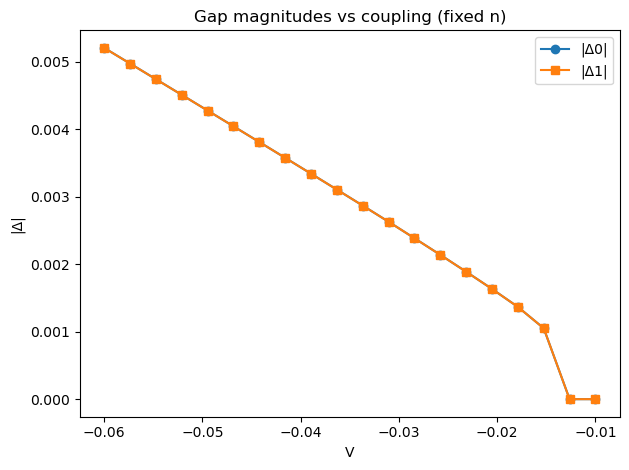

In [8]:
import matplotlib.pyplot as plt
#  
V   = np.array([r["V"]  for r in results], float)
D0  = np.array([r["Δ0"] for r in results], complex)
D1  = np.array([r["Δ1"] for r in results], complex)
MU  = np.array([r["μ"]  for r in results], float)
NN  = np.array([r["n"]  for r in results], float)
RES = np.array([r["resnorm"] for r in results], float)

plt.figure()
plt.plot(V, np.abs(D0), "o-", label="|Δ0|")
plt.plot(V, np.abs(D1), "s-", label="|Δ1|")
plt.xlabel("V"); plt.ylabel("|Δ|"); plt.title("Gap magnitudes vs coupling (fixed n)"); 
plt.legend(); 
plt.tight_layout()


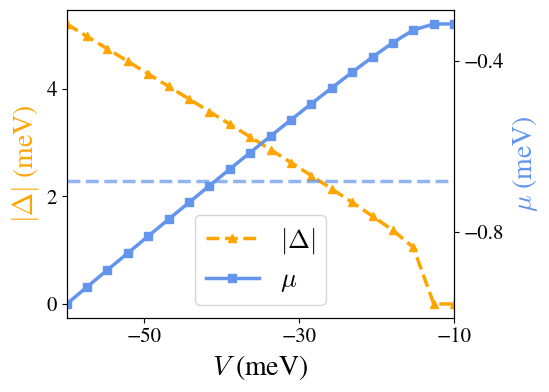

In [96]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
matplotlib.rcParams["mathtext.fontset"] = "cm"
matplotlib.rcParams["font.family"] = "STIXGeneral"

# --- data ---
V   = np.array([r["V"]  for r in results], float)      # e.g. meV
D0  = np.array([r["Δ0"] for r in results], complex)
D1  = np.array([r["Δ1"] for r in results], complex)
MU  = np.array([r["μ"]  for r in results], float)

# --- figure ---
fig, ax = plt.subplots(figsize=(5, 4))

# Left axis: gaps
#l0, = ax.plot(V, np.abs(D0), "o-",  lw=2.5, ms=6, label=r"$|\Delta_0|$")
l1, = ax.plot(1000*V, 1000*np.abs(D1), "^--",color="orange", lw=2.5, ms=6, label=r"$|\Delta|$")
ax.set_xlabel(r"$V$ (meV)", fontsize=20)
ax.set_ylabel(r"$|\Delta|$ (meV)", fontsize=20,color="orange")
ax.tick_params(labelsize=15)

# Right axis: chemical potential
ax2 = ax.twinx()
m1, = ax2.plot(1000*V, 1000*(MU-0.00145947), "s-", lw=2.5, ms=5.5, label=r"$\mu$",color="cornflowerblue")
ax2.set_ylabel(r"$\mu$ (meV)", fontsize=20,color="cornflowerblue")
ax2.tick_params(labelsize=15)

# Optional: same x-limits for both
ax.set_xlim(1000*V.min(), 1000*V.max())

# One combined legend (from both axes)
handles = [ l1, m1]
labels  = [h.get_label() for h in handles]
ax.legend(handles, labels, fontsize=19, loc="lower center")

# Cosmetics
#ax.grid(True, alpha=0.25)
#plt.title(r"Gaps and $\mu$ vs coupling $V$", fontsize=20)
ref=1.46

ax.set_xticks([-10,-30,-50])     # x ticks for V
ax.set_yticks([0.0, 2,4])     # left y ticks for |Δ|
ax2.set_yticks([-0.8,-0.4] ) 
ax2.axhline(-0.68, linestyle="--", linewidth=2.5,  alpha=0.7,color="cornflowerblue", label=r"$\mu=0.8$")

plt.savefig("figs/fig5.pdf", bbox_inches="tight")

